# COGS118B 2022FA
##### Group members:
#### Alexander Huynh, Andrina / Xiaoxuan Zhang, Nicolas Schaefer, Victorionna Tran

presentation video: 


presentation slides: https://docs.google.com/presentation/d/1pluFLWJl29U45WkxpcH_bu0kdAwriR8w6QYsswkTnms/edit#slide=id.p

# Background

Everything happening with nature has tremendous impacts on human beings. Earthquakes and natural disasters may take away countless people's lives. Earthquake prediction has been around for a while but has yielded no real success and our group wants to work on this topic too.

At the very beginning of the project, our group wanted to work on the time series data of earthquake waveforms, trying to predict how the wave may traverse to predict the earthquake's severity. However, the data we could find online was not very ideal to predict the waveform. 

Fortunately, we are able to find a dataset that contains the Data, Time, Latitude, Longitude, Magnitude, Depth, and Region of the earthquake. The core components made us possible to work on the earthquake prediction model.

# Research Question

#### Can we accurately predict the magnitude and depth of an earthquake happening, given the time and location (latitude and longitude) it will occur?


We would like to know the relationship between the time and location of earthquakes
The general prediction and patterns on magnitude and depth of earthquakes may also apply to the decision of future urban planning and architect designs
With the consideration of these components, the government may design different focuses based on different locations to decrease the effect of earthquakes. With further influence, this work’s importance pertains to the livelihood of people.

# Data

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
import tensorflow as tf
import keras

2022-12-06 08:32:32.444173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-06 08:32:32.444211: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.wrappers.scikit_learn import KerasClassifier

### Importing data

In [4]:
df = pd.read_csv('clean25kDataset.csv')

In [5]:
timestamp_list = []
for d, t in zip(df['Date'], df['Time']):
    timestamp = datetime.datetime.strptime(d+' '+t, '%Y-%m-%d %H:%M:%S')
    timestamp_list.append(time.mktime(timestamp.timetuple()))
    
timeStamp = pd.Series(timestamp_list)
df['Timestamp'] = timeStamp.values
clean_df = df.drop(['Date', 'Time'], axis=1)

clean_df = clean_df.rename(columns={'Lat': 'Latitude', 'Lon': 'Longitude', 'Mag': 'Magnitude'})
clean_df

,Latitude,Longitude,Depth,Magnitude,Region,Timestamp
0,60.5758,-147.5620,15.1,2.6,"57 km SW of Tatitlek, Alaska",1.670283e+09
1,37.3565,-121.7167,8.2,1.5,"10km E of Alum Rock, CA",1.670283e+09
2,60.1315,-153.1349,125.6,1.9,"66 km E of Port Alsworth, Alaska",1.670282e+09
3,37.3247,-121.6887,6.9,3.7,"13km ESE of Alum Rock, CA",1.670282e+09
4,39.4327,-92.2425,4.7,2.5,"5 km SSW of Madison, Missouri",1.670282e+09
...,...,...,...,...,...,...
24995,58.2855,-154.9823,3.8,0.5,"85 km NNW of Karluk, Alaska",1.664120e+09
24996,51.3816,142.7739,10.0,4.8,"51 km NE of Mgachi, Russia",1.664120e+09
24997,27.7017,56.4543,10.0,4.9,"59 km NNE of Bandar Abbas, Iran",1.664120e+09
24998,35.3747,-118.1223,4.5,1.1,"30km NNW of California City, CA",1.664119e+09


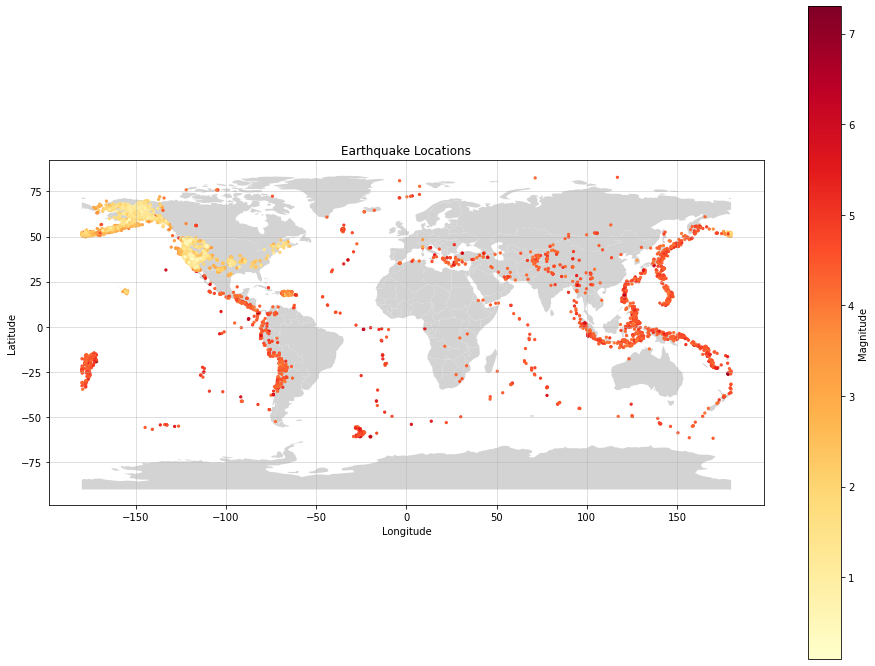

In [6]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# initialize an axis
fig, ax = plt.subplots(figsize=(16,12))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

# plot points
clean_df.plot(x="Longitude", y="Latitude", marker ='.', kind="scatter", c="Magnitude", colormap="YlOrRd", 
        title="Earthquake Locations", ax=ax)

# add grid
ax.grid(visible=True, alpha=0.5)

plt.show()

In [7]:
X = clean_df[['Timestamp', 'Latitude', 'Longitude']]
y = clean_df[['Magnitude', 'Depth']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(20000, 3) (5000, 3) (20000, 2) (5000, 2)


# Implementing Neural Network

#### Model-1
### Baseline Neural Network

In [9]:
def NN(neurons, drop, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(rate=drop))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [16]:
test = NN(32, 0.5, 'relu', 'SGD', 'squared_hinge')
test_plot = test.fit(X_train, y_train, batch_size= 64, epochs= 40, verbose=2, validation_data=(X_test,y_test))

[test_loss, test_acc] = test.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Epoch 1/40
313/313 - 1s - loss: 0.6147 - accuracy: 0.8526 - val_loss: 0.6419 - val_accuracy: 0.9170 - 1s/epoch - 4ms/step
Epoch 2/40
313/313 - 1s - loss: 0.6151 - accuracy: 0.8497 - val_loss: 0.6419 - val_accuracy: 0.9170 - 675ms/epoch - 2ms/step
Epoch 3/40
313/313 - 1s - loss: 0.6179 - accuracy: 0.8498 - val_loss: 0.6419 - val_accuracy: 0.9170 - 743ms/epoch - 2ms/step
Epoch 4/40
313/313 - 1s - loss: 0.6150 - accuracy: 0.8530 - val_loss: 0.6419 - val_accuracy: 0.9170 - 779ms/epoch - 2ms/step
Epoch 5/40
313/313 - 1s - loss: 0.6146 - accuracy: 0.8507 - val_loss: 0.6419 - val_accuracy: 0.9170 - 812ms/epoch - 3ms/step
Epoch 6/40
313/313 - 1s - loss: 0.6156 - accuracy: 0.8504 - val_loss: 0.6419 - val_accuracy: 0.9170 - 826ms/epoch - 3ms/step
Epoch 7/40
313/313 - 1s - loss: 0.6168 - accuracy: 0.8555 - val_loss: 0.6419 - val_accuracy: 0.9170 - 777ms/epoch - 2ms/step
Epoch 8/40
313/313 - 1s - loss: 0.6164 - accuracy: 0.8525 - val_loss: 0.6419 - val_accuracy: 0.9170 - 731ms/epoch - 2ms/step
Epo

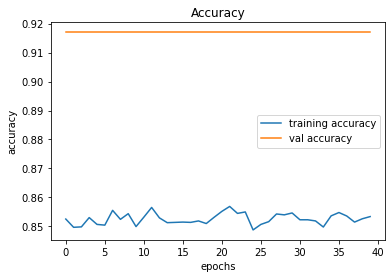

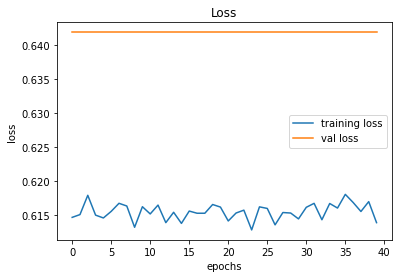

In [17]:
plt.figure(0)
plt.plot(test_plot.history['accuracy'], label='training accuracy')
plt.plot(test_plot.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(test_plot.history['loss'], label='training loss')
plt.plot(test_plot.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In the graphs we can see as the model is going through more epochs the training and validation are imporoving. We can also see a convergence of the accuracies in the later stages. We see that the loss is getting smaller and converging.

### Baseline Neural Network Hyperparameter Tuning

With the parameters we estimate that might be a great input, we already have an decent accuracy. We will try hyper parameter tunning now to see if we can fine tune the model for better accuracy.

In [18]:
neurons = [32, 64, 128]
batches = [50, 100, 200]
dropout = [0.1, 0.2, 0.25, 0.5] 
activation = ['relu', 'tanh', 'sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
loss = ['categorical_crossentropy', 'poisson', 'kl_divergence', 'squared_hinge']
epochs = [40]
search_space = dict(neurons=neurons, batch_size = batches, drop = dropout, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

These will be the hyperparameters that we are going to tune our Neural network: 
- Batches is the batch size of the data, it is the amount data points in a single partition that is going to be passed through our Neural Network, the higher the value the faster it runs. 
- Dropout is the dropout rate of the data, it is primarily used to compensate for overfitting, we are going to use 1 dropout rate for hypertuning. 
- Filter size is the size of our filter for the neural network, in this case we have to run a smaller filter on the latter half of our NN. 
- Epoch is the number of times we are going to train our neural network. It will always tune in hyperparameter tuning, but 40 epochs would be a solid number.

As stated above we decided to tune these four specific hyperparameters: batch size, drop out rate, filter size and epoch. While smaller batch sizes generally give a better result, we did not want to suffer the consequence of a high computation cost. Therefore, we choose these three batch sizes to run with 32, 64 and 128. The dropout rate allows for better accuracy because it can help with overfitting. For this hyperparameter we chose: 0.1, 0.2, 0.25 and 0.5. Lastly, we decided it was best to leave the epoch size to 40. This is because any larger size would greatly increase the runtime and computation load. 

In [19]:
clf_keras = KerasClassifier(build_fn = NN, verbose = 0)

/tmp/ipykernel_41859/2273775274.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf_keras = KerasClassifier(build_fn = NN, verbose = 0)


We will wrap our tensorflow function into a Scikit learn wrapper in order to do our cross validation and randomized search.

In [20]:
rand = RandomizedSearchCV(estimator=clf_keras, param_distributions=search_space, verbose= 3, cv = 5)

This cross validation will be a randomized search CV, since it will take a lot of computation and time to perform a grid search on the every possible combination of hyperparameters that we have in our dictionary. Utilizing randomized search CV as the cross validation, will allow us to perform a search on all the hyperparameter combinations to find the best ones while still remaining efficient. With five cross validation folds and ten candidates, we will end with fifty runs for our cross validation. 

In [21]:
rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END activation=relu, batch_size=50, drop=0.5, epochs=40, loss=categorical_crossentropy, neurons=32, optimizer=Adam;, score=0.741 total time=  23.6s
[CV 2/5] END activation=relu, batch_size=50, drop=0.5, epochs=40, loss=categorical_crossentropy, neurons=32, optimizer=Adam;, score=0.753 total time=  22.6s
[CV 3/5] END activation=relu, batch_size=50, drop=0.5, epochs=40, loss=categorical_crossentropy, neurons=32, optimizer=Adam;, score=0.744 total time=  23.0s
[CV 4/5] END activation=relu, batch_size=50, drop=0.5, epochs=40, loss=categorical_crossentropy, neurons=32, optimizer=Adam;, score=0.741 total time=  22.9s
[CV 5/5] END activation=relu, batch_size=50, drop=0.5, epochs=40, loss=categorical_crossentropy, neurons=32, optimizer=Adam;, score=0.747 total time=  22.0s
[CV 1/5] END activation=sigmoid, batch_size=50, drop=0.2, epochs=40, loss=squared_hinge, neurons=128, optimizer=Nadam;, score=0.741 total time=  35.2s
[CV

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4e34580610>,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'sigmoid', 'linear'],
                                        'batch_size': [50, 100, 200],
                                        'drop': [0.1, 0.2, 0.25, 0.5],
                                        'epochs': [40],
                                        'loss': ['categorical_crossentropy',
                                                 'poisson', 'kl_divergence',
                                                 'squared_hinge'],
                                        'neurons': [32, 64, 128],
                                        'optimizer': ['SGD', 'RMSprop',
                                                      'Adagrad', 'Adadelta',
                                                      'Adam', 'Adamax',
                     

After tuning the fitting of our randomized search, we came up with the best score below.

In [22]:
rand.best_score_

0.7453999996185303

These are the parameters that resulted in the best score:

In [23]:
params = rand.best_params_
params

{'optimizer': 'Adam',
 'neurons': 32,
 'loss': 'categorical_crossentropy',
 'epochs': 40,
 'drop': 0.5,
 'batch_size': 50,
 'activation': 'relu'}

In [29]:
hyper = NN(neurons=32, drop= 0.5, activation='relu', optimizer='Adam', loss='categorical_crossentropy')
hyper_plot = hyper.fit(X_train, y_train, batch_size= 50, epochs= 40, validation_data=(X_test,y_test))

[test_loss, test_acc] = hyper.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Epoch 1/40
400/400 [==============================] - 1s 3ms/step - loss: 15735300096.0000 - accuracy: 0.8802 - val_loss: 39592742912.0000 - val_accuracy: 0.9170
Epoch 2/40
400/400 [==============================] - 1s 2ms/step - loss: 96205340672.0000 - accuracy: 0.8601 - val_loss: 111738462208.0000 - val_accuracy: 0.9170
Epoch 3/40
400/400 [==============================] - 1s 3ms/step - loss: 250909458432.0000 - accuracy: 0.8124 - val_loss: 178581749760.0000 - val_accuracy: 0.9170
Epoch 4/40
400/400 [==============================] - 1s 2ms/step - loss: 525025705984.0000 - accuracy: 0.7572 - val_loss: 185003507712.0000 - val_accuracy: 0.9170
Epoch 5/40
400/400 [==============================] - 1s 2ms/step - loss: 1023428984832.0000 - accuracy: 0.6779 - val_loss: 196580605952.0000 - val_accuracy: 0.9170
Epoch 6/40
400/400 [==============================] - 1s 2ms/step - loss: 1764850532352.0000 - accuracy: 0.6406 - val_loss: 163681370112.0000 - val_accuracy: 0.9170
Epoch 7/40
400/40

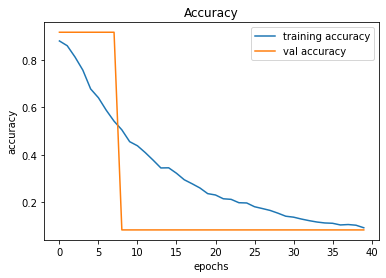

In [30]:
plt.plot(hyper_plot.history['accuracy'], label='training accuracy')
plt.plot(hyper_plot.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

The fine tuned parameters work not as good as the parameters we designed to input might be caused by our limitation of data or the processing power, since we used RandomizedSearchCV instead of GridSearchCV.

#### Model-2
###  SVR

In [31]:
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm

In [32]:
df = pd.read_csv('clean25kDataset.csv')

In [33]:
timestamp_list = []
for d, t in zip(df['Date'], df['Time']):
    timestamp = datetime.datetime.strptime(d+' '+t, '%Y-%m-%d %H:%M:%S')
    timestamp_list.append(time.mktime(timestamp.timetuple()))
    
timeStamp = pd.Series(timestamp_list)
df['Timestamp'] = timeStamp.values
clean_df = df.drop(['Date', 'Time'], axis=1)

clean_df = clean_df.rename(columns={'Lat': 'Latitude', 'Lon': 'Longitude', 'Mag': 'Magnitude'})
clean_df


,Latitude,Longitude,Depth,Magnitude,Region,Timestamp
0,60.5758,-147.5620,15.1,2.6,"57 km SW of Tatitlek, Alaska",1.670283e+09
1,37.3565,-121.7167,8.2,1.5,"10km E of Alum Rock, CA",1.670283e+09
2,60.1315,-153.1349,125.6,1.9,"66 km E of Port Alsworth, Alaska",1.670282e+09
3,37.3247,-121.6887,6.9,3.7,"13km ESE of Alum Rock, CA",1.670282e+09
4,39.4327,-92.2425,4.7,2.5,"5 km SSW of Madison, Missouri",1.670282e+09
...,...,...,...,...,...,...
24995,58.2855,-154.9823,3.8,0.5,"85 km NNW of Karluk, Alaska",1.664120e+09
24996,51.3816,142.7739,10.0,4.8,"51 km NE of Mgachi, Russia",1.664120e+09
24997,27.7017,56.4543,10.0,4.9,"59 km NNE of Bandar Abbas, Iran",1.664120e+09
24998,35.3747,-118.1223,4.5,1.1,"30km NNW of California City, CA",1.664119e+09


In [34]:
max(clean_df['Magnitude'])

7.3

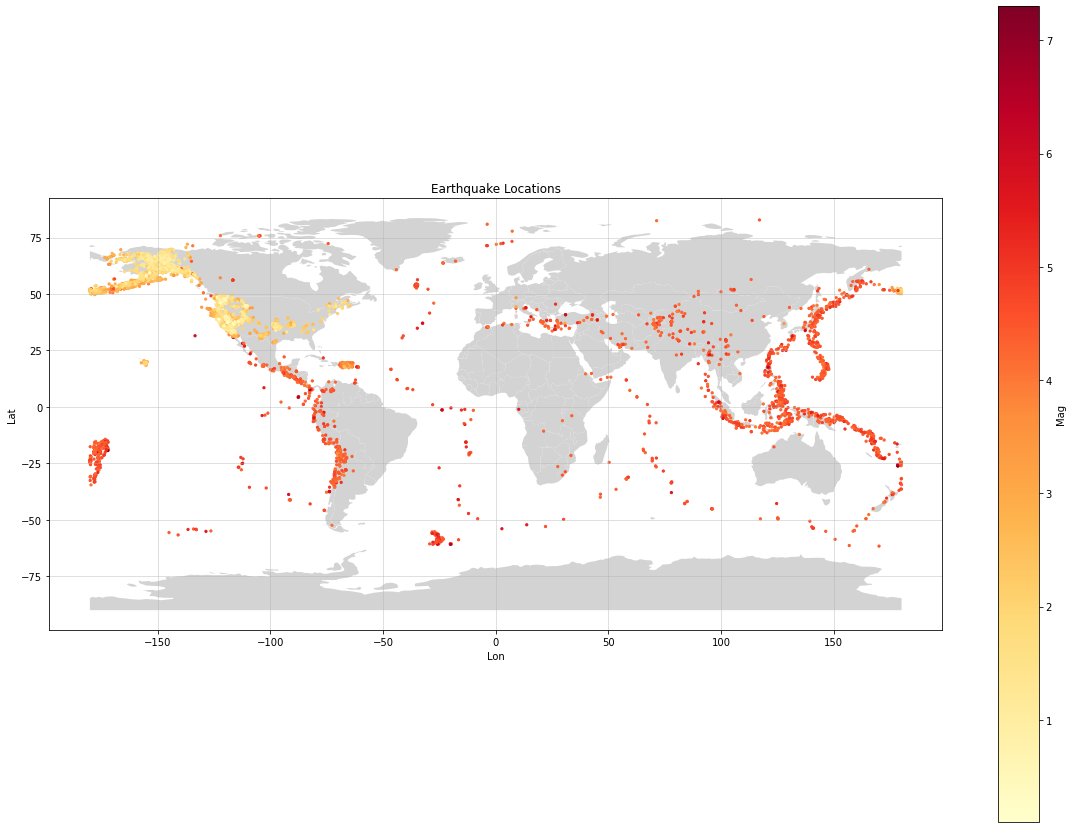

In [35]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# initialize an axis
fig, ax = plt.subplots(figsize=(20,15))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

# plot points
df.plot(x="Lon", y="Lat", marker ='.', kind="scatter", c="Mag", colormap="YlOrRd", 
        title="Earthquake Locations", ax=ax)

# add grid
ax.grid(visible=True, alpha=0.5)

plt.show()


In [36]:
X = clean_df[['Timestamp', 'Latitude', 'Longitude']]
y = clean_df[['Magnitude']]
X = X.to_numpy() 
y = y.to_numpy().reshape(-1, 1)

In [37]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [38]:
svr = SVR().fit(X, y.ravel())
yfit = svr.predict(X)

In [39]:
X = sc_X.inverse_transform(X)
y = sc_y.inverse_transform(y)
yfit = sc_y.inverse_transform(yfit)

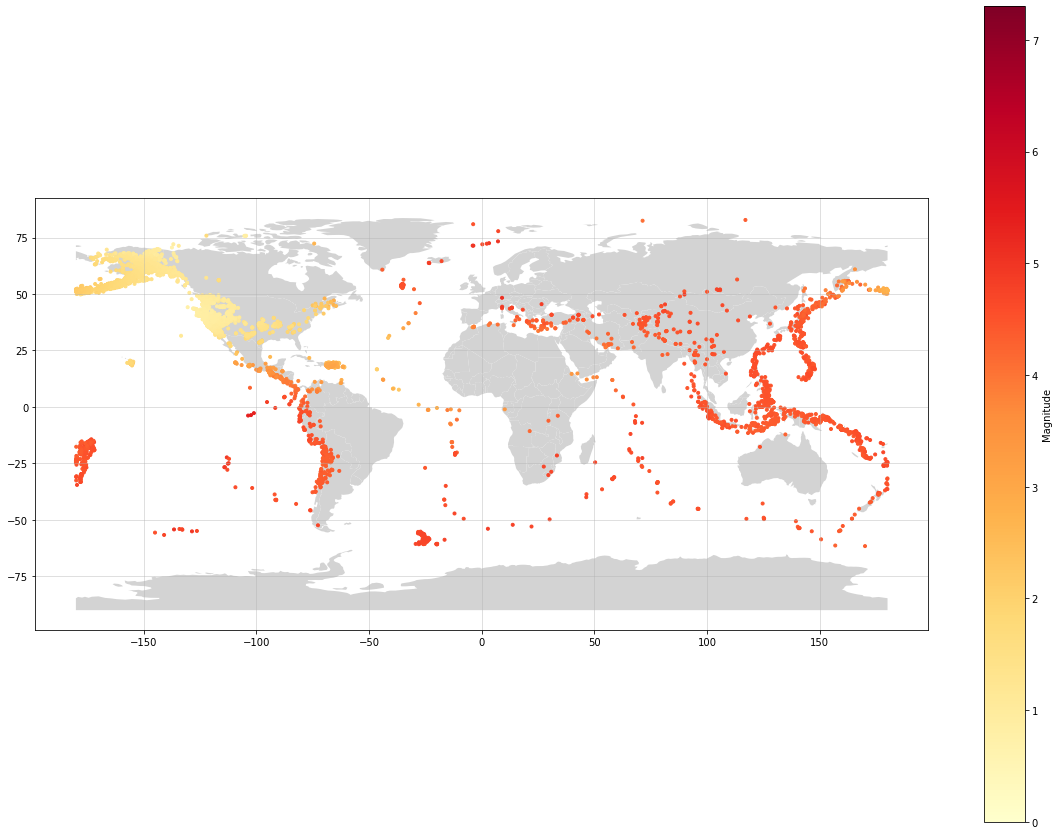

In [40]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# initialize an axis
fig, ax = plt.subplots(figsize=(20,15))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

# plot points
plt.scatter(X[:,2], X[:,1], marker ='.', c=yfit)
plt.set_cmap("YlOrRd")
plt.colorbar(label="Magnitude", orientation="vertical")
plt.clim(0,7.3)

# add grid
ax.grid(visible=True, alpha=0.5)

plt.show()

In [41]:
score = svr.score(X,y[:,0])
print("R-squared:", score)
print("MSE:", mean_squared_error(y[:,0], yfit))

R-squared: -0.10852553290586431
MSE: 0.37817285756014696


In [42]:
yfit = yfit.reshape(-1,1)
newy = y-yfit
newy = np.power(newy,2)
newy = newy.reshape(-1,1)

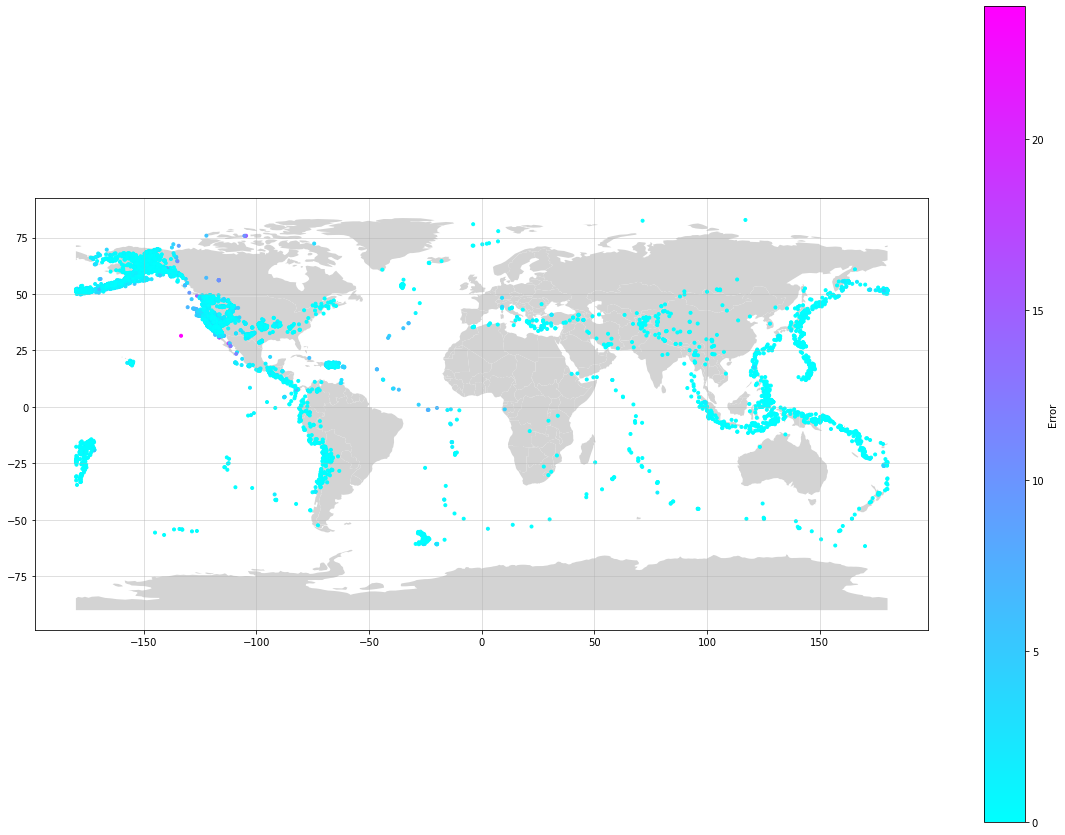

In [43]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# initialize an axis
fig, ax = plt.subplots(figsize=(20,15))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

# plot points
plt.scatter(X[:,2], X[:,1], marker ='.', c=newy)
plt.set_cmap("cool")
plt.colorbar(label="Error", orientation="vertical")

# add grid
ax.grid(visible=True, alpha=0.5)

plt.show()

# Results

From the graph and the verbose of fitting the data into our model, it looks like our hyperparameter tuned model is OVERFITTING/UNDERFITTING to the training data. We can see the intersection of the two accuracy values within our graph. Our training accuracy is higher than the validation accuracy. It is a semi accurate model, with a INSERT PERCENT validation accuracy. We can try implementing our model with fewer epochs in order to combat the OVERFITTING of training data.


Compared to the base model of our hyperparameter tuned model, the hyper-tuned model overfitted with the training data set. The validation accuracy of the base model is INSERT PERCENT with a training accuracy of INSERT PERCENT, while the hyper tuned model has a validation accuracy of INSERT PERCENT with a INSERT PERCENT training accuracy. Overall the base NN model would be the better performer out of the two models. We could have done a grid search, to find the best true hyperparameters, but that would be computationally expensive.


One of the reasons, our baseline model did better was due to the custom parameters we choose were not optimal for the dataset to begin with. 

# Discussion

#### What did we learn?
- Data Sets
    - Machine learning prediction models have the better accuracy when working with very large datasets. The first two datasets we used were quite small and resulted in poor outcomes or did not go work with the model at all. 
- Models
    - Initially we attempted to use LeNetas our model and we got it to work but the results were poor. This was most likely due to the fact that LeNet are mainly used as a models for image prediction and classification, which is not what we were doing.  
#### How can we improve?
- Data
    - More data. Our dataset collects the earthquakes from September 25th, 2022 to December 5th, 2022 (the moment we collected the data). So the dataset was small and might because of seasonal effects on tectonic features, the data isn’t representative enough. 
    - With more processing power we could use larger datasets for a more generalized picture
- Time
    - One major limitation was time and processing power
    - Because of the processing power and the numbers of the hyper-parameters we wanted to test out, it takes too long for us to utilize the GridSearchCV in order to find better hyper-parameters than purely using RandomizedSearchCV. 


# Team Contributions
- Alexander Huynh: Researching models, Creating model, Tuning the algorithm, Slides & Video presentation
- Andrina / Xiaoxuan Zhang: Finding data, Model implementation, Testing & tuning the algorithm, Slides & Video presentation
- Nicolas Schaefer: Data collecting & cleaning, Slides & Video presentation
- Victorionna Tran: Data cleaning & wrangling, Data visualization, Slides & Video presentation